# Importing required libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.layers import BatchNormalization

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data prepration

In [5]:
file_path = '/content/drive/MyDrive/action_recognition/dataset20.csv'
dataset = pd.read_csv(file_path) #reading the dataset

In [6]:
print(dataset.shape) #checking its shape

(321428, 21)


In [7]:
dataset.head() #taking a look at the dataset

,lastSensorEventHours,lastSensorEventSeconds,windowDuration,prevDominantSensor1,prevDominantSensor2,lastSensorID,lastSensorLocation,lastMotionLocation,sensorCount-Bathroom,sensorCount-Bedroom,sensorCount-Ignore,sensorCount-Kitchen,sensorCount-LivingRoom,sensorCount-OutsideDoor,sensorElTime-Bathroom,sensorElTime-Bedroom,sensorElTime-DiningRoom,sensorElTime-Kitchen,sensorElTime-LivingRoom,sensorElTime-OutsideDoor,label
0,-0.439845,-0.407339,-0.283800,-1.545536,-1.545432,0.180151,0.180151,1.465175,-0.455621,-0.510093,1.433035,-0.500411,-0.806492,4.371657,13.780628,15.748974,10.111505,12.958303,18.366668,-0.706324,26
1,-0.439845,-0.407291,-0.282950,-1.545536,-1.545432,1.731450,1.731450,1.465175,-0.455621,-0.510093,1.457228,-0.500411,-0.806492,4.301066,13.780628,15.748974,10.111505,12.958303,18.366668,-0.706652,26
2,-0.439845,-0.401850,-0.189541,-1.545536,-1.545432,0.180151,0.180151,1.465175,-0.455621,-0.510093,1.443221,-0.500411,-0.806492,4.341935,13.780628,15.748974,10.111505,12.958303,18.366668,-0.686144,26
3,-0.439845,-0.401658,-0.186993,-1.545536,-1.545432,0.180151,0.180151,1.465175,-0.455621,-0.510093,1.429215,-0.500411,-0.806492,4.382803,13.780628,15.748974,10.111505,12.958303,18.366668,-0.685372,26
4,-0.439845,-0.401658,-0.187842,-1.545536,-1.545432,1.731450,1.731450,1.465175,-0.455621,-0.510093,1.287872,-0.500411,-0.806492,4.795202,13.780628,15.748974,10.111505,12.958303,18.366668,-0.706652,26


In [8]:
def generate_seqences(dataset): #this function returns our sequences and their labels
  sequences = [] #sequences will be stored in this list
  labels = [] #labels of seaquences will be stored in this list
  time_step = 32 #each seq will include 32 rows of our table
  stride = 1 #number of rows we slide at each iteration
  num_sequences = len(dataset) - time_step + stride #number of sequences
  for i in range(num_sequences):
    start = i #fist index of sequence number i
    end = i + time_step - stride #last index of sequence number i
    sequences.append(dataset.iloc[start:end+1,:-1]) #fetching rows of features
    labels.append(dataset.iloc[end,-1]) #fetching the label of last row in a sequence
  return sequences,labels

In [9]:
sequences,labels = generate_seqences(dataset) #generates a lit of sequences 
sequences= np.stack(sequences) #numpy array of shape (num_sequences,16,21)
labels = np.stack(labels) #numpy array of shape (num_sequences,)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2) #spliting sequences into train and test sets
y_train = to_categorical(y_train) #onehot encoding
y_test = to_categorical(y_test) #onehot encoding

In [11]:
print(f"length of X_train: {X_train.shape}")
print(f"length of y_train: {y_train.shape}")
print(f"length of X_test: {X_test.shape}")
print(f"length of y_test: {y_test.shape}")

length of X_train: (257117, 32, 20)
length of y_train: (257117, 35)
length of X_test: (64280, 32, 20)
length of y_test: (64280, 35)


In [12]:
n_timesteps, n_features, n_outputs =   X_train.shape[1], X_train.shape[2], y_train.shape[1]
n_steps, n_length = 2 , 16
#اhar timestep ra be 2 gheteye 16tai taghsim kardeim. sepas rooye harkodam az anha feature extraction anjam mishavad.

X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features)) # the 2nd dimmension is broken down into two dimmensions
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features)) # the 2nd dimmension is broken down into two dimmensions

In [13]:
print(f"length of X_train: {X_train.shape}")
print(f"length of y_train: {y_train.shape}")
print(f"length of X_test: {X_test.shape}")
print(f"length of y_test: {y_test.shape}")

length of X_train: (257117, 2, 16, 20)
length of y_train: (257117, 35)
length of X_test: (64280, 2, 16, 20)
length of y_test: (64280, 35)


# Defining and training a Conv-LSTM model

In [ ]:
num_epochs = 20
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'), input_shape=(None,n_length,n_features)))
#applying convolution layer with 64 filters on each data point
model.add(TimeDistributed(Dropout(0.5)))
#applying dropout to avoid ovefitting
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
#applying maxpool layer to reduce the number of parameters and keep the most important features
model.add(TimeDistributed(Flatten()))

model.add(LSTM(200, return_sequences=True)) #the output will have 3 dimensionals
#adding an LSTM layer with 200 neurons
#model.add(BatchNormalization())

model.add(LSTM(200))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))
#adding a dense layer with 100 neurons and relu activation
model.add(Dense(n_outputs, activation='softmax'))
#adding a dense layer with 35 neurons and softmax activaion

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#compling the model with categorical cross entropy loss function and adam optimizer

start_time = time.time() #start time of training
history = model.fit(X_train, y_train, validation_split=0.1, epochs=num_epochs, batch_size=128) #training the model
print(f'elapsed time: {time.time() - start_time}') #print the time duration of training

Epoch 1/20
3616/3616 [==============================] - 88s 23ms/step - loss: 0.8626 - accuracy: 0.7048 - val_loss: 0.6744 - val_accuracy: 0.7572
Epoch 2/20
3616/3616 [==============================] - 85s 23ms/step - loss: 0.6394 - accuracy: 0.7713 - val_loss: 0.5644 - val_accuracy: 0.7946
Epoch 3/20
3616/3616 [==============================] - 85s 24ms/step - loss: 0.5486 - accuracy: 0.8014 - val_loss: 0.4921 - val_accuracy: 0.8230
Epoch 4/20
3616/3616 [==============================] - 84s 23ms/step - loss: 0.4893 - accuracy: 0.8225 - val_loss: 0.4444 - val_accuracy: 0.8376
Epoch 5/20
3616/3616 [==============================] - 85s 24ms/step - loss: 0.4487 - accuracy: 0.8361 - val_loss: 0.4221 - val_accuracy: 0.8467
Epoch 6/20
3616/3616 [==============================] - 84s 23ms/step - loss: 0.4169 - accuracy: 0.8475 - val_loss: 0.4060 - val_accuracy: 0.8513
Epoch 7/20
3616/3616 [==============================] - 85s 23ms/step - loss: 0.3934 - accuracy: 0.8558 - val_loss: 0.3740 -

# Results

In [ ]:
_ ,accuracy = model.evaluate(X_test, y_test, batch_size=128)
print(accuracy)

0.9073272943496704


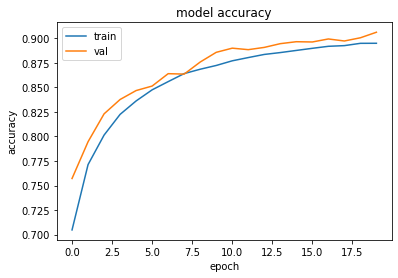

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

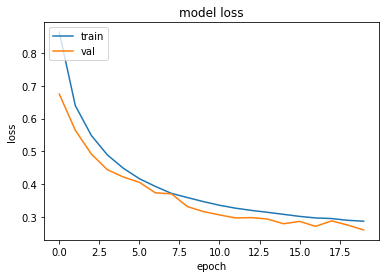

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Dynamic hyperparameter tuning

In [14]:
!pip install keras-tuner==1.0.0

     |████████████████████████████████| 88 kB 5.5 MB/s 
     |████████████████████████████████| 462 kB 37.8 MB/s 


In [15]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [26]:
def build_model(hp):

  model = Sequential()
  model.add(TimeDistributed(Conv1D(32, kernel_size=5, activation='relu', padding='same'), input_shape=(None,n_length,n_features)))
  model.add(TimeDistributed(Dropout(0.5)))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

  model.add(TimeDistributed(Flatten()))

  for i in range (hp.Int("n_layers",1,5)):
    model.add(LSTM(hp.Int(f"input_{i}_units", min_value=50, max_value=200, step=50)))
  model.add(LSTM(200))

  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [27]:
tuner = RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials = 1,
    executions_per_trial = 1
)

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-26-66f55c4b6568>", line 12, in build_model
    model.add(LSTM(200))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/tracking/base.py", line 629, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/input_spec.py", line 214, in assert_input_compatibility
    raise ValueError(f'Input {input_index} of layer "{layer_name}" '
ValueError: Input 0 of layer "lstm_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 50)


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-26-66f55c4b6568>", line 12, in build_model
    model.add(LSTM(200))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/tracking/base.py", line 629, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/input_spec.py", line 214, in assert_input_compatibility
    raise ValueError(f'Input {input_index} of layer "{layer_name}" '
ValueError: Input 0 of layer "lstm_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 50)


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-26-66f55c4b6568>", line 12, in build_model
    model.add(LSTM(200))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/tracking/base.py", line 629, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/input_spec.py", line 214, in assert_input_compatibility
    raise ValueError(f'Input {input_index} of layer "{layer_name}" '
ValueError: Input 0 of layer "lstm_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 50)


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-26-66f55c4b6568>", line 12, in build_model
    model.add(LSTM(200))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/tracking/base.py", line 629, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/input_spec.py", line 214, in assert_input_compatibility
    raise ValueError(f'Input {input_index} of layer "{layer_name}" '
ValueError: Input 0 of layer "lstm_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 50)


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-26-66f55c4b6568>", line 12, in build_model
    model.add(LSTM(200))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/tracking/base.py", line 629, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/input_spec.py", line 214, in assert_input_compatibility
    raise ValueError(f'Input {input_index} of layer "{layer_name}" '
ValueError: Input 0 of layer "lstm_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 50)


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-26-66f55c4b6568>", line 12, in build_model
    model.add(LSTM(200))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/tracking/base.py", line 629, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/input_spec.py", line 214, in assert_input_compatibility
    raise ValueError(f'Input {input_index} of layer "{layer_name}" '
ValueError: Input 0 of layer "lstm_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 50)


RuntimeError: ignored

In [23]:
tuner.search(x=X_train,
             y=y_train,
             epochs = 10,
             batch_size = 256,
             validation_data = (X_test, y_test))

NameError: ignored